In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-alwkuwev
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-alwkuwev
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-11r4sely/pydoe_23ee80247aa548e2878d43b757077d75
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-11r4sely/pydoe_23ee80247aa548e2878d43b757077d75
     |████████████████████████████████| 316 kB 5.3 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=58303c378ddf6ab002b5c0860d1f5e4cd1e383e582f2ddf91bc7bf07f7db6813
  Stored in directory: /tmp/pip-ephem-wheel-cache-z

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F21
from bayes_optim.search_space import RealSpace

In [3]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f21'
f = F21

samples = space.sample(50000)

In [4]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [5]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [6]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [8]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'cma_es_regret', 'min_dist_to_opt': 'dopt_cma'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_init_regret', 'min_dist_to_opt': 'dopt_init'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'uniform_regret', 'min_dist_to_opt': 'dopt_uni'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_regret', 'min_dist_to_opt': 'dopt_lhs'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'halton_regret', 'min_dist_to_opt': 'dopt_hal'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'sobol_regret', 'min_dist_to_opt': 'dopt_sob'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,2.040101,0,1.110406,0.781008,1.415238,1.640512,2.912746,1.293377,1.745873,1.945677,1.197383,0.124528,0.676170,74.153645,14.867465
1,2.001350,1,2.552424,1.508079,0.961308,1.497197,1.201673,0.000019,1.543233,1.876513,2.071614,1.057082,1.665529,67.441584,14.022947
2,0.312547,2,2.340340,0.059103,0.920926,1.308344,2.315452,2.062354,1.425322,0.014321,0.529703,0.001151,0.208770,69.298127,13.869459
3,0.000021,3,0.051085,0.031800,0.674971,0.122102,0.315926,4.263554,2.251950,2.925804,2.565205,0.054090,0.598895,79.989812,15.281448
4,1.426581,4,2.470158,2.003578,2.016559,1.477616,3.403665,1.385505,1.439010,0.142842,0.889417,3.021603,1.064582,67.194252,16.155706


# CMA-ES vs first individual (generated by LHS)

In [9]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES improved lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
3,3,0.000021,0.054090,0.051085,0.598895
4,4,1.426581,3.021603,2.470158,1.064582
5,5,0.000080,0.829551,2.217098,2.958140
7,7,0.565978,1.510823,2.051360,3.077306
8,8,0.261284,0.989150,1.118468,1.938671
11,11,1.894104,1.894352,3.087173,2.697108
16,16,1.390439,1.573401,1.062931,1.455585
18,18,0.048374,1.553685,0.377367,1.390499
20,20,0.000109,0.114835,0.605381,0.997302
22,22,1.992640,2.030927,2.163149,1.660250


In [10]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES worstened lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
0,0,2.040101,0.124528,1.110406,0.676170
1,1,2.001350,1.057082,2.552424,1.665529
2,2,0.312547,0.001151,2.340340,0.208770
6,6,2.308872,1.153547,2.355278,1.327170
9,9,1.443118,0.601055,0.942233,0.601789
10,10,1.624026,0.848313,1.055602,2.081732
12,12,1.012498,0.100454,2.182252,1.208629
13,13,0.442997,0.134668,0.623647,0.263679
14,14,2.012146,0.014895,2.367251,0.956965
15,15,0.042732,0.014759,0.760905,1.151381


# CMA-ES generated vs Uniform

In [11]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret', 'dopt_cma', 'dopt_uni']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 22, (44.0%) function instances


,f_s,cma_es_regret,uniform_regret,dopt_cma,dopt_uni
3,3,0.000021,0.031800,0.051085,0.674971
4,4,1.426581,2.003578,2.470158,2.016559
5,5,0.000080,0.003356,2.217098,1.741510
7,7,0.565978,1.885525,2.051360,3.000787
8,8,0.261284,2.045049,1.118468,0.703569
10,10,1.624026,1.733087,1.055602,1.388950
15,15,0.042732,0.198722,0.760905,1.428888
18,18,0.048374,2.927704,0.377367,2.186454
20,20,0.000109,0.360539,0.605381,1.537555
24,24,1.469178,1.953017,1.279597,2.539782


# CMA-ES vs LHS

In [12]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret', 'dopt_cma', 'dopt_lhs']]

DoE generated by CMA-ES is better than lhs sampled DoE on 22 (44.0%) function instances


,f_s,cma_es_regret,lhs_regret,dopt_cma,dopt_lhs
2,2,0.312547,1.308344,2.340340,2.315452
3,3,0.000021,0.122102,0.051085,0.315926
4,4,1.426581,1.477616,2.470158,3.403665
5,5,0.000080,0.124376,2.217098,1.688398
8,8,0.261284,1.589899,1.118468,1.878828
10,10,1.624026,1.743485,1.055602,2.169080
12,12,1.012498,1.105774,2.182252,3.214176
15,15,0.042732,1.657484,0.760905,2.712928
16,16,1.390439,1.938734,1.062931,1.325092
17,17,1.891926,2.078202,1.069855,1.496663


# CMA-ES vs Sobol

In [13]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret', 'dopt_cma', 'dopt_sob']]

DoE generated by CMA-ES is better than sobol generated DoE on 16 (32.0%) function instances


,f_s,cma_es_regret,sobol_regret,dopt_cma,dopt_sob
2,2,0.312547,2.062354,2.340340,1.425322
3,3,0.000021,4.263554,0.051085,2.251950
5,5,0.000080,2.029054,2.217098,1.070591
7,7,0.565978,0.853740,2.051360,2.481954
12,12,1.012498,1.983424,2.182252,1.605623
15,15,0.042732,1.934478,0.760905,0.883810
18,18,0.048374,0.351375,0.377367,1.147688
20,20,0.000109,0.012078,0.605381,2.639457
28,28,0.501183,1.334059,1.434723,2.673222
29,29,0.000006,1.961899,0.341115,2.595307


# CMA-ES vs Halton

In [14]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret', 'dopt_cma', 'dopt_hal']]

DoE generated by CMA-ES is better than halton generated DoE on 18 (36.0%) function instances


,f_s,cma_es_regret,halton_regret,dopt_cma,dopt_hal
3,3,0.000021,2.925804,0.051085,2.565205
5,5,0.000080,2.028212,2.217098,2.039549
8,8,0.261284,0.629061,1.118468,1.948116
10,10,1.624026,2.048777,1.055602,2.025828
12,12,1.012498,1.607579,2.182252,3.122572
13,13,0.442997,1.112633,0.623647,2.072601
18,18,0.048374,0.052556,0.377367,1.011289
20,20,0.000109,0.331965,0.605381,2.603249
25,25,1.673930,2.038604,2.366842,1.267753
28,28,0.501183,1.772048,1.434723,3.024588


In [15]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 8 (16.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
3,0.000021,3,0.051085,0.031800,0.674971,0.122102,0.315926,4.263554,2.251950,2.925804,2.565205,0.054090,0.598895,79.989812,15.281448
5,0.000080,5,2.217098,0.003356,1.741510,0.124376,1.688398,2.029054,1.070591,2.028212,2.039549,0.829551,2.958140,73.912832,14.646836
18,0.048374,18,0.377367,2.927704,2.186454,0.479912,2.163384,0.351375,1.147688,0.052556,1.011289,1.553685,1.390499,69.574638,18.256356
20,0.000109,20,0.605381,0.360539,1.537555,1.981985,2.389727,0.012078,2.639457,0.331965,2.603249,0.114835,0.997302,78.368712,16.257695
28,0.501183,28,1.434723,2.118033,1.967312,1.832817,3.167116,1.334059,2.673222,1.772048,3.024588,0.006593,1.707668,70.241200,17.358894
29,0.000006,29,0.341115,2.035080,2.646424,1.800279,1.594585,1.961899,2.595307,0.488455,1.162453,0.001732,1.576259,65.155591,15.020632
32,0.003109,32,1.926836,1.340244,3.019488,0.496552,1.898392,1.993429,1.179530,0.901151,2.177191,0.052211,1.035086,66.396357,15.775742
37,0.069096,37,1.151014,2.294196,2.221480,1.359141,0.893084,0.716645,2.606614,1.773887,1.388805,1.195531,1.217064,70.379986,15.084000


In [16]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,2.040101,0,1.110406,0.781008,1.415238,1.640512,2.912746,1.293377,1.745873,1.945677,1.197383,0.124528,0.676170,74.153645,14.867465
11,1.894104,11,3.087173,0.009804,0.986187,0.959220,2.670964,0.086503,0.959664,1.766429,3.235438,1.894352,2.697108,67.368208,16.542304
12,1.012498,12,2.182252,0.159256,0.892014,1.105774,3.214176,1.983424,1.605623,1.607579,3.122572,0.100454,1.208629,71.468299,17.092114
17,1.891926,17,1.069855,0.014870,1.669289,2.078202,1.496663,1.576031,1.347262,0.602337,2.819174,0.014612,0.613586,71.689847,16.486591
19,2.024754,19,0.836122,0.072809,3.056920,2.059869,2.283897,1.942137,1.641246,1.577211,1.674552,0.751687,1.856548,67.281300,15.017833
21,1.396499,21,2.293243,0.003062,0.771788,1.849402,0.542929,1.053770,2.573428,0.873950,2.979116,1.145295,1.196616,68.222151,13.730251
25,1.673930,25,2.366842,0.012212,1.552667,0.016463,1.520260,0.096177,0.579961,2.038604,1.267753,0.014838,1.180032,64.223116,14.803811
26,1.775639,26,1.621776,0.001051,1.218902,1.656648,1.618758,0.032639,1.350654,1.688764,1.846028,0.513624,1.953237,71.937607,15.341651
44,1.333505,44,0.931279,0.014104,0.126559,0.045632,2.011423,2.025806,1.821105,1.116743,1.709784,1.906292,1.225110,62.401711,13.630372
47,1.576736,47,2.444513,0.018143,4.224086,0.940256,3.321314,1.501820,1.662785,1.395046,2.504201,2.694609,1.927263,65.926585,14.975783


In [17]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 9 (18.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
2,0.312547,2,2.340340,0.059103,0.920926,1.308344,2.315452,2.062354,1.425322,0.014321,0.529703,0.001151,0.208770,69.298127,13.869459
4,1.426581,4,2.470158,2.003578,2.016559,1.477616,3.403665,1.385505,1.439010,0.142842,0.889417,3.021603,1.064582,67.194252,16.155706
6,2.308872,6,2.355278,1.303668,0.678126,2.106749,2.922972,1.982067,2.286012,0.755047,0.713445,1.153547,1.327170,68.182226,15.946303
7,0.565978,7,2.051360,1.885525,3.000787,0.304081,1.328278,0.853740,2.481954,0.022876,0.932334,1.510823,3.077306,65.885618,15.932243
15,0.042732,15,0.760905,0.198722,1.428888,1.657484,2.712928,1.934478,0.883810,0.014665,0.976084,0.014759,1.151381,70.037380,17.180109
30,2.008298,30,2.977680,0.539172,0.841637,0.843414,2.460830,1.712544,2.035208,0.003656,0.961408,0.040338,2.330405,57.221232,14.247030
34,1.517048,34,2.235535,0.003592,2.407934,0.994169,2.040500,0.015727,1.445204,0.000028,1.528937,0.016592,2.186757,62.702370,15.199019
36,1.110887,36,0.415916,1.372419,3.978959,1.053002,1.862186,3.891461,2.531436,0.439326,0.714378,1.966777,1.106088,67.336388,14.812148
48,1.647458,48,1.475420,1.869262,1.004381,1.452058,2.362704,0.016355,2.729393,0.009043,1.008769,0.043653,1.049986,55.594087,13.993815


In [18]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
9,1.443118,9,0.942233,0.034877,1.289730,0.007981,3.321676,1.067959,1.524408,0.153538,0.907490,0.601055,0.601789,68.025440,14.640273
13,0.442997,13,0.623647,0.003291,1.900274,0.000251,1.427556,0.018414,1.544945,1.112633,2.072601,0.134668,0.263679,60.213826,13.930526
14,2.012146,14,2.367251,1.618151,1.668123,0.042098,1.444725,0.151659,1.154439,0.587183,0.447412,0.014895,0.956965,65.479535,13.787088
23,2.605462,23,1.295383,1.096425,4.066189,0.360502,0.289000,0.559466,1.602975,1.727184,1.482513,1.556399,1.457599,65.910416,14.354333
33,1.579150,33,2.754861,0.190260,3.309369,0.000037,0.907023,0.040640,1.194890,0.242595,2.212854,1.840251,1.646685,68.822520,14.944620
38,0.482497,38,1.964104,0.934083,2.080988,0.123616,0.690753,1.375407,1.194027,0.489900,1.456787,0.068998,1.315128,74.657950,16.041306
39,0.671792,39,1.700383,2.016562,1.899200,0.007466,0.730507,1.690768,2.517569,0.139861,0.629891,2.204895,0.704654,68.088541,16.504730
40,2.042931,40,1.571278,1.696314,0.670515,0.008344,2.057574,0.011490,0.993422,0.011233,0.985303,0.511144,1.770529,72.160757,16.430530
41,1.704378,41,1.696908,1.899011,1.917102,0.814122,1.362664,1.003804,0.705842,2.020599,1.854732,2.062198,1.413824,69.725094,15.281180
46,2.212875,46,2.364575,0.913389,2.492667,0.164776,1.303178,1.079658,2.845941,1.992594,1.081218,1.711656,1.277339,71.940171,14.608008


In [19]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,2.040101,0,1.110406,0.781008,1.415238,1.640512,2.912746,1.293377,1.745873,1.945677,1.197383,0.124528,0.676170,74.153645,14.867465
2,0.312547,2,2.340340,0.059103,0.920926,1.308344,2.315452,2.062354,1.425322,0.014321,0.529703,0.001151,0.208770,69.298127,13.869459
12,1.012498,12,2.182252,0.159256,0.892014,1.105774,3.214176,1.983424,1.605623,1.607579,3.122572,0.100454,1.208629,71.468299,17.092114
14,2.012146,14,2.367251,1.618151,1.668123,0.042098,1.444725,0.151659,1.154439,0.587183,0.447412,0.014895,0.956965,65.479535,13.787088
17,1.891926,17,1.069855,0.014870,1.669289,2.078202,1.496663,1.576031,1.347262,0.602337,2.819174,0.014612,0.613586,71.689847,16.486591
28,0.501183,28,1.434723,2.118033,1.967312,1.832817,3.167116,1.334059,2.673222,1.772048,3.024588,0.006593,1.707668,70.241200,17.358894
31,1.956582,31,1.590079,1.022134,2.615848,1.266693,1.364951,0.470474,1.305133,1.920708,3.782991,0.000450,0.096174,64.818061,14.328423
38,0.482497,38,1.964104,0.934083,2.080988,0.123616,0.690753,1.375407,1.194027,0.489900,1.456787,0.068998,1.315128,74.657950,16.041306


In [20]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 13 (26.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
1,2.001350,1,2.552424,1.508079,0.961308,1.497197,1.201673,0.000019,1.543233,1.876513,2.071614,1.057082,1.665529,67.441584,14.022947
8,0.261284,8,1.118468,2.045049,0.703569,1.589899,1.878828,0.000541,2.065280,0.629061,1.948116,0.989150,1.938671,80.040011,13.960077
10,1.624026,10,1.055602,1.733087,1.388950,1.743485,2.169080,0.017327,2.111054,2.048777,2.025828,0.848313,2.081732,69.151237,13.955363
16,1.390439,16,1.062931,0.663463,2.543992,1.938734,1.325092,0.504459,2.081559,0.886686,3.069997,1.573401,1.455585,72.377909,15.525266
22,1.992640,22,2.163149,0.732634,1.406553,0.256109,0.513294,0.001940,0.560193,0.699413,3.443406,2.030927,1.660250,61.430501,13.956987
24,1.469178,24,1.279597,1.953017,2.539782,2.707048,1.330023,0.000218,0.191060,0.002830,1.375569,1.957251,1.628318,71.130580,14.724533
27,0.124474,27,0.466489,0.099355,2.513861,1.969942,2.309167,0.003969,0.548968,0.011164,2.017909,1.560529,1.895249,67.596223,14.681138
31,1.956582,31,1.590079,1.022134,2.615848,1.266693,1.364951,0.470474,1.305133,1.920708,3.782991,0.000450,0.096174,64.818061,14.328423
35,2.116017,35,1.523084,0.479671,1.457780,0.504827,1.977842,0.013645,0.967614,1.695428,2.034363,2.021015,1.695747,70.244700,15.438449
42,0.292722,42,1.030863,2.073155,3.643962,1.329865,1.514864,0.065670,2.538847,0.753269,1.244281,1.283388,1.368720,59.323360,14.800001


([<matplotlib.axis.XTick at 0x7fa9bd40b850>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

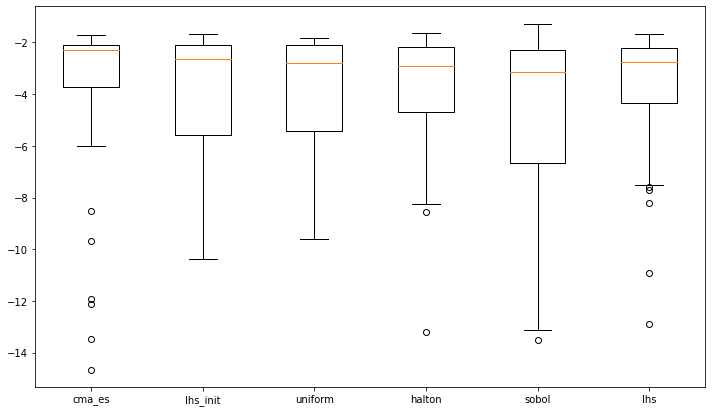

In [21]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7fa9bd522250>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

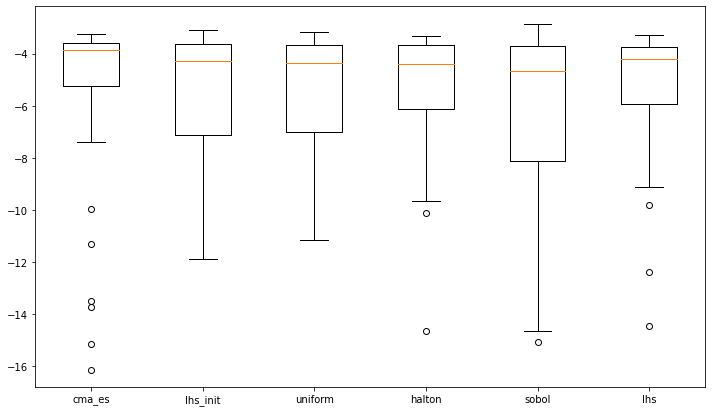

In [22]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)